Camera index with data_frame starting at 1: 0


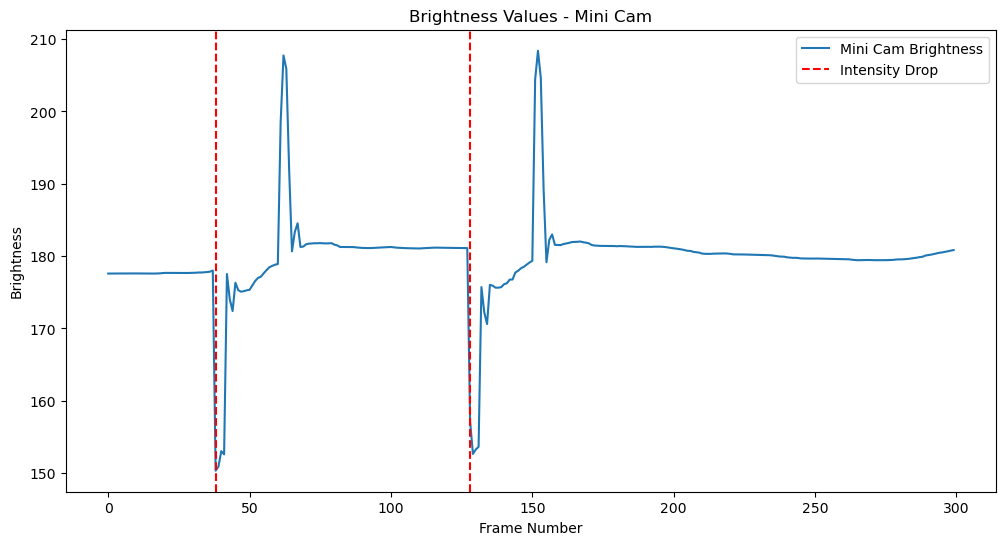

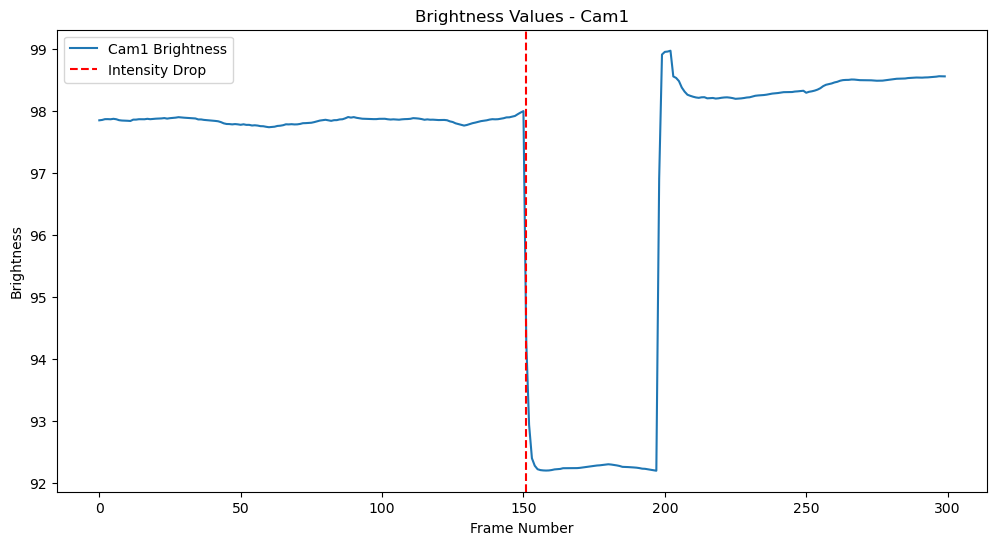

offset:  -2509.8932560000085
Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_15_42/MIR_Aligned/aligned_predictions.h5
aligned_pred_3d_flat.shape: (8917, 66)
aligned_pred_3d.shape: (8917, 3, 22)
aligned_com.shape: (8917, 3)


In [1]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.mini_dannce_sync import sync_videos, align_miniscope_to_sixcam


rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_15_42' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/data/big_rim/mir_data/Oct3V1mini/Oct3V1mini_sorted/20241002-pmc-r2/customEntValHere/2024_10_25/15_50_39' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'
resultsss = sync_videos(
    rec_path,
    mini_path,
    start_frame=0,
    end_frame=300,
    threshold_mini=20,
    threshold_sixcam=3
)

align_miniscope_to_sixcam(resultsss, mini_path, rec_path)


Data loaded successfully!


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

hdf5_input_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions.h5')

df = pd.read_hdf(hdf5_input_path, key='df')
mini_cam_timestamps = df.index.values
print("Data loaded successfully!")
# print(df.head())



# rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
# mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'

# miniscope data paths
miniscope_path = os.path.join(mini_path, 'My_V4_Miniscope')
miniscope_timestamps_path = os.path.join(miniscope_path, 'timeStamps.csv')

# nc file containing Ca imaging data
nc_files = glob.glob(os.path.join(miniscope_path, '*.nc'))
if not nc_files:
    raise FileNotFoundError("No .nc files found in the specified miniscope path.")
ca_file_path = nc_files[0]

# The Ca data is stored in a .nc file. We'll load it using xarray.
data = xr.open_dataset(ca_file_path)

# The timestamps for Ca data:
timestamps = pd.read_csv(miniscope_timestamps_path)
ts = timestamps['Time Stamp (ms)'].values  # shape (num_ca_frames,)

C = data['C'].values
num_neuron, num_frame = C.shape
print("Calcium data shape:", C.shape)
print("Timestamps shape:", ts.shape)


C_interpolated = []
for i_neuron in range(num_neuron):
    # Create an interpolation function for each neuron
    func = interp1d(ts, C[i_neuron, :], kind='linear', bounds_error=False, fill_value='extrapolate')
    neuron_interp = func(mini_cam_timestamps)
    C_interpolated.append(neuron_interp)

C_interpolated = np.array(C_interpolated)  # shape (num_neuron, N_miniscope_frames)
print("Interpolated Ca data shape:", C_interpolated.shape)

Data loaded successfully!
Calcium data shape: (96, 8954)
Timestamps shape: (8954,)
Interpolated Ca data shape: (96, 8917)


In [4]:
# We'll add columns for each neuron, like calcium_roi0, calcium_roi1, etc.
calcium_cols = [f'calcium_roi{i}' for i in range(num_neuron)]

# Transpose C_interpolated to match DataFrame dimensions (N_miniscope_frames, num_neuron)
C_interpolated_transposed = C_interpolated.T  # shape (N_miniscope_frames, num_neuron)

# Create a DataFrame for Ca data
df_ca = pd.DataFrame(data=C_interpolated_transposed, index=mini_cam_timestamps, columns=calcium_cols)
df_ca.index.name = 'timestamp_ms'

# Merge with the existing df
df_merged = df.join(df_ca, how='inner')
print("Data with Ca signals merged:")
# print(df_merged.head())

Data with Ca signals merged:


In [5]:
updated_hdf5_path = os.path.join(rec_path, 'MIR_Aligned', 'aligned_predictions_with_ca.h5')
df_merged.to_hdf(updated_hdf5_path, key='df', mode='w')
print(f"Updated DataFrame with Ca data saved to {updated_hdf5_path}")


Updated DataFrame with Ca data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_15_42/MIR_Aligned/aligned_predictions_with_ca.h5


Correlation between com_x and calcium_roi0: -0.24724837726617696


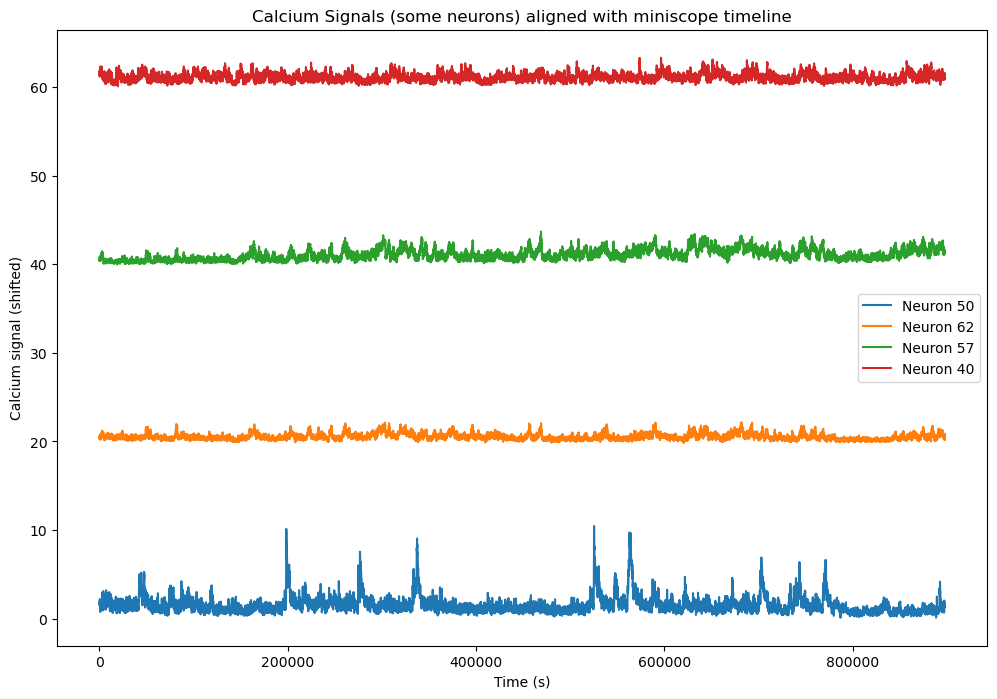

In [7]:

# Check correlation of a calcium ROI with com_x as an example
r = df_merged['com_x'].corr(df_merged['calcium_roi0'])
print("Correlation between com_x and calcium_roi0:", r)

# Plot a few neurons over time
plt.figure(figsize=(12, 8))
selected_neurons = [50, 62, 57, 40] #[0, 1, 2]  # first 3 neurons for example
for i, neuron_idx in enumerate(selected_neurons):
    plt.plot(df_merged.index, df_merged[f'calcium_roi{neuron_idx}'] + i*20, label=f'Neuron {neuron_idx}')

plt.xlabel('Time (s)')
plt.ylabel('Calcium signal (shifted)')
plt.title('Calcium Signals (some neurons) aligned with miniscope timeline')
plt.legend()
plt.show()

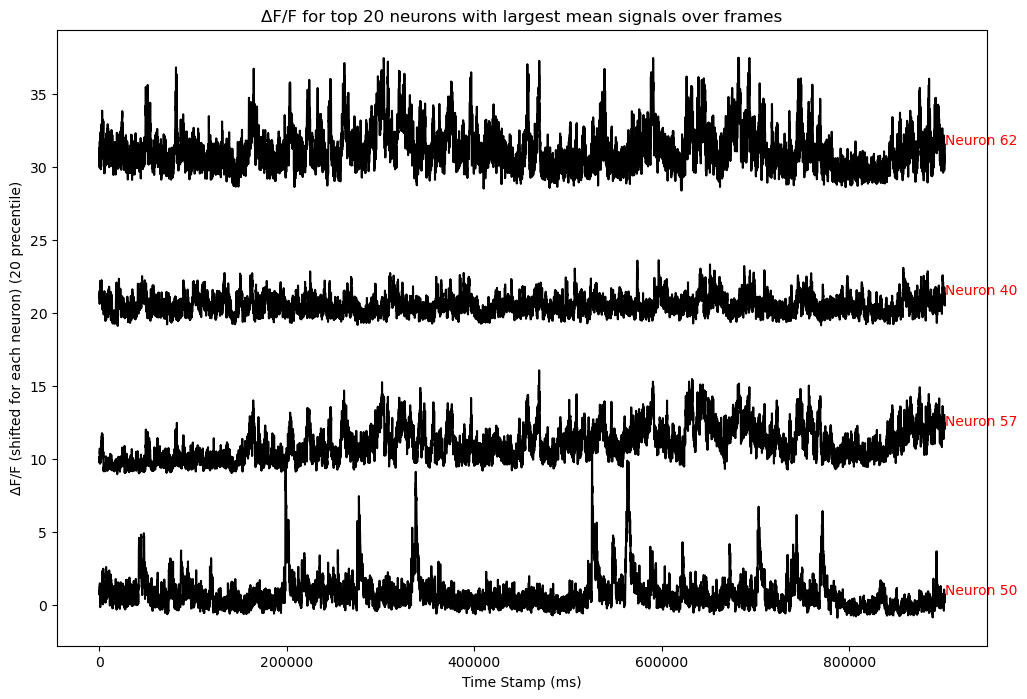

Top 20 neuron indices by mean ΔF/F (20 precentile) value:
[50, 57, 40, 62]


In [11]:
C = data['C'].values
selected_indices = [50, 57, 40, 62]

# Calculate F0 (the baseline) for each neuron as the 10th percentile of fluorescence
F0 = np.percentile(C, 20, axis=1, keepdims=True)

# Calculate ΔF/F for each neuron
dF_F = (C - F0) / F0

# Plot the ΔF/F values for each selected neuron and print their indices for manual selection, with timestamps
plt.figure(figsize=(12, 8))
for i, neuron_index in enumerate(selected_indices):
    plt.plot(ts, dF_F[neuron_index] + i * 10, color='black', label=f'Neuron {neuron_index}')  # Set the color to black
    plt.text(ts[-1], dF_F[neuron_index][-1] + i * 10, f'Neuron {neuron_index}', color='red')  # Annotate each neuron index

plt.xlabel('Time Stamp (ms)')
plt.ylabel('ΔF/F (shifted for each neuron) (20 precentile)')
plt.title('ΔF/F for top 20 neurons with largest mean signals over frames')
plt.show()

# Print the selected neuron indices for reference
print("Top 20 neuron indices by mean ΔF/F (20 precentile) value:")
print(selected_indices)


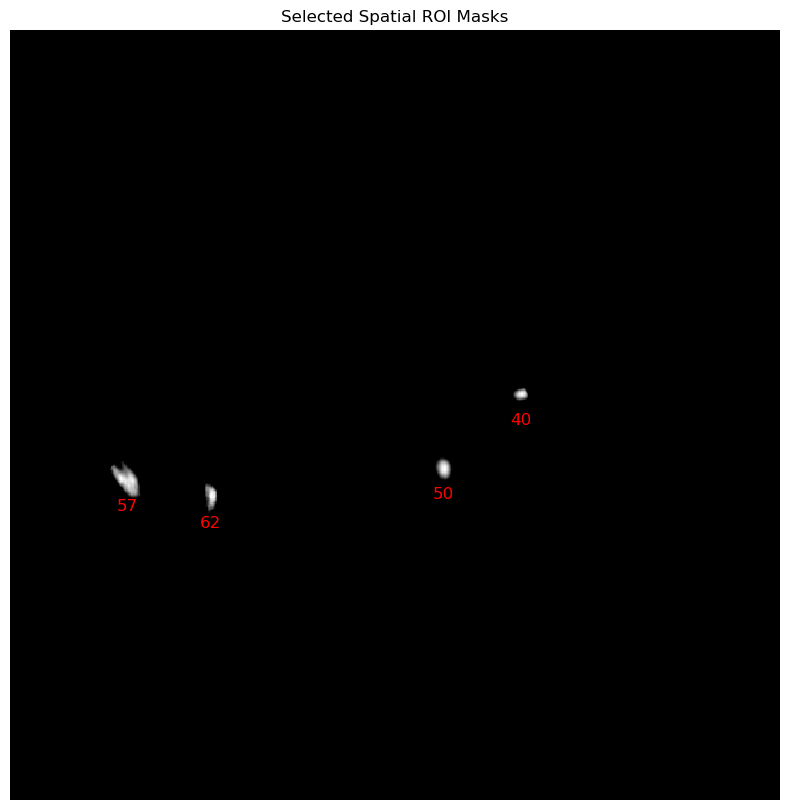

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix


A = np.array(data['A'].values)
# Convert from sparse to dense if necessary (CSC or CSR format typically)
try:
    A_dense = csc_matrix((A.data, A.indices, A.indptr), shape=A.shape).toarray()
except AttributeError:
    # If 'A' is already dense
    A_dense = A

# Manually selected ROI indices
manual_selection = [50, 57, 40, 62]

# Create an empty image to combine selected ROIs
selected_rois = np.zeros_like(A_dense[0])

# Add selected ROIs to the image
for roi in manual_selection:
    selected_rois += A_dense[roi]

# Clip values to ensure binary representation (0 or 1)
selected_rois = np.clip(selected_rois, 0, 1)

# Plot the selected ROIs
plt.figure(figsize=(10, 10))
plt.imshow(selected_rois, cmap='gray', interpolation='nearest')

# Annotate each selected ROI with its index slightly below the overlay
for roi in manual_selection:
    # Find the centroid of the ROI to place the annotation
    coords = np.argwhere(A_dense[roi] > 0)
    if len(coords) > 0:
        centroid = coords.mean(axis=0)
        plt.text(centroid[1], centroid[0] + 20, str(roi), color='red', fontsize=12, ha='center', va='center')

plt.title('Selected Spatial ROI Masks')
plt.axis('off')
plt.show()


Correlations of selected ROIs with com_x:
calcium_roi57: r=0.166, p=4.406e-56
calcium_roi50: r=-0.108, p=2.381e-24
calcium_roi40: r=0.101, p=1.687e-21
calcium_roi62: r=-0.023, p=3.150e-02


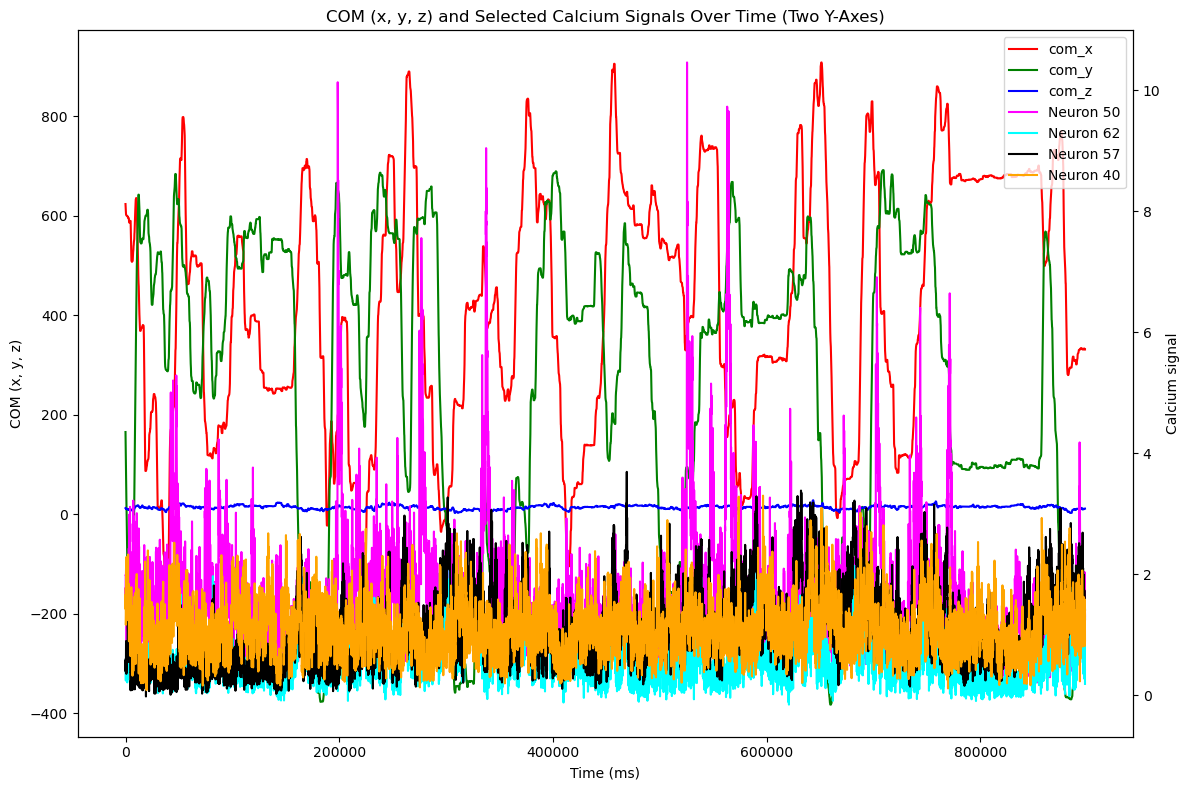

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Ensure these columns exist in df_merged
for col in ['com_x', 'com_y', 'com_z']:
    if col not in df_merged.columns:
        raise ValueError(f"{col} not found in df_merged.")

# Define selected neurons
selected_neurons = [50, 62, 57, 40]  # Specific neurons to correlate and visualize

# Check if selected neuron ROIs exist in the data
selected_roi_names = [f'calcium_roi{neuron}' for neuron in selected_neurons]
for roi in selected_roi_names:
    if roi not in df_merged.columns:
        raise ValueError(f"{roi} not found in df_merged.")

#########################################
# Compute Correlations (com_x vs selected ROIs)
#########################################
corr_values = {}
for roi in selected_roi_names:
    r, p_val = pearsonr(df_merged['com_x'], df_merged[roi])
    corr_values[roi] = (r, p_val)

# Sort by absolute correlation to find top correlated ROIs
sorted_corrs = sorted(corr_values.items(), key=lambda x: abs(x[1][0]), reverse=True)

print("Correlations of selected ROIs with com_x:")
for roi, (r, p_val) in sorted_corrs:
    print(f"{roi}: r={r:.3f}, p={p_val:.3e}")

#########################################
# Visualization with Two Y-Axes
#########################################

fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot COM_x, COM_y, COM_z on the left y-axis
ax1.plot(df_merged.index, df_merged['com_x'], color='red', label='com_x')
ax1.plot(df_merged.index, df_merged['com_y'], color='green', label='com_y')
ax1.plot(df_merged.index, df_merged['com_z'], color='blue', label='com_z')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('COM (x, y, z)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the calcium signals
ax2 = ax1.twinx()

# Plot the selected neurons
colors = ['magenta', 'cyan', 'black', 'orange']  # Colors for selected neurons
for i, roi_name in enumerate(selected_roi_names):
    ax2.plot(df_merged.index, df_merged[roi_name], color=colors[i % len(colors)],
             label=f'Neuron {selected_neurons[i]}')

ax2.set_ylabel('Calcium signal', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('COM (x, y, z) and Selected Calcium Signals Over Time (Two Y-Axes)')
plt.tight_layout()
plt.show()


Top 5 ROIs by correlation with com_x:
calcium_roi79: r=0.344, p=1.952e-245
calcium_roi92: r=0.341, p=2.004e-241
calcium_roi73: r=0.338, p=1.595e-236
calcium_roi86: r=0.333, p=5.436e-230
calcium_roi91: r=0.328, p=2.655e-223


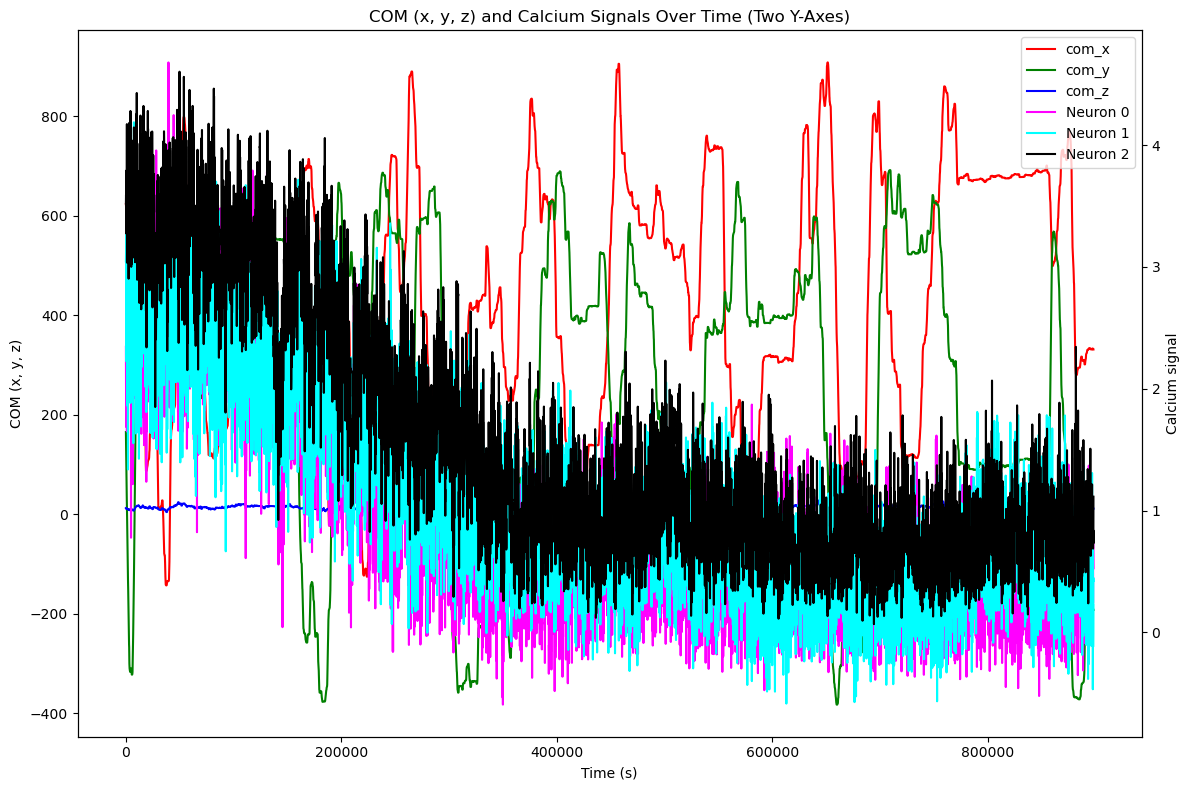

In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr
# import numpy as np

# # Ensure these columns exist in df_merged
# for col in ['com_x', 'com_y', 'com_z']:
#     if col not in df_merged.columns:
#         raise ValueError(f"{col} not found in df_merged.")

# calcium_cols = [col for col in df_merged.columns if col.startswith('calcium_roi')]
# if not calcium_cols:
#     raise ValueError("No calcium_roi columns found in df_merged.")

# #########################################
# # Compute Correlations (example: com_x vs all ROIs)
# #########################################
# corr_values = {}
# for roi in calcium_cols:
#     r, p_val = pearsonr(df_merged['com_x'], df_merged[roi])
#     corr_values[roi] = (r, p_val)

# # Sort by absolute correlation to find top correlated ROIs
# sorted_corrs = sorted(corr_values.items(), key=lambda x: abs(x[1][0]), reverse=True)

# print("Top 5 ROIs by correlation with com_x:")
# for roi, (r, p_val) in sorted_corrs[:5]:
#     print(f"{roi}: r={r:.3f}, p={p_val:.3e}")

# #########################################
# # Visualization with Two Y-Axes
# #########################################

# fig, ax1 = plt.subplots(figsize=(12, 8))

# # Plot COM_x, COM_y, COM_z on the left y-axis
# ax1.plot(df_merged.index, df_merged['com_x'], color='red', label='com_x')
# ax1.plot(df_merged.index, df_merged['com_y'], color='green', label='com_y')
# ax1.plot(df_merged.index, df_merged['com_z'], color='blue', label='com_z')
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('COM (x, y, z)', color='black')
# ax1.tick_params(axis='y', labelcolor='black')

# # Create a second y-axis for the calcium signals
# ax2 = ax1.twinx()

# # Select a few neurons for visualization
# selected_neurons = [0, 1, 2]  # first 3 neurons for example
# colors = ['magenta', 'cyan', 'black']  # different colors for each neuron

# for i, neuron_idx in enumerate(selected_neurons):
#     roi_name = f'calcium_roi{neuron_idx}'
#     if roi_name in df_merged.columns:
#         ax2.plot(df_merged.index, df_merged[roi_name], color=colors[i],
#                  label=f'Neuron {neuron_idx}')

# ax2.set_ylabel('Calcium signal', color='black')
# ax2.tick_params(axis='y', labelcolor='black')

# # Combine legends from both axes
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# plt.title('COM (x, y, z) and Calcium Signals Over Time (Two Y-Axes)')
# plt.tight_layout()
# plt.show()


In [15]:
import numpy as np
from sklearn.decomposition import PCA

# Identify keypoint columns
kp_cols = [col for col in df_merged.columns if col.startswith('kp')]

# Extract keypoint data as a NumPy array: shape (N_frames, 66)
X_keypoints = df_merged[kp_cols].values

# Store each frame's keypoints as a single vector in a new column
# Each cell will contain a 1D numpy array of length 66
df_merged['keypoints_vector'] = list(X_keypoints)

print("Added 'keypoints_vector' column to df_merged:")
print(df_merged[['keypoints_vector']].head())

##############################################################
# Using PCA to reduce keypoints_vector to a few components
##############################################################

# PCA: from 66 dimensions down to, say, 5 principal components
pca = PCA(n_components=5)
keypoints_pca = pca.fit_transform(X_keypoints)  # shape (N_frames, 5)

# Add these PCs as new columns to df_merged
for i in range(5):
    df_merged[f'kp_PC{i+1}'] = keypoints_pca[:, i]

print("Keypoint PCs added:")
print(df_merged[['kp_PC1', 'kp_PC2', 'kp_PC3', 'kp_PC4', 'kp_PC5']].head())

##############################################################
# Correlating Keypoint PCs with COM or Calcium
##############################################################

# Example: Correlate kp_PC1 with com_x
r_com_x = df_merged['kp_PC1'].corr(df_merged['com_x'])
print("Correlation between kp_PC1 and com_x:", r_com_x)

# If you have calcium signals, e.g. calcium_roi0:
if 'calcium_roi0' in df_merged.columns:
    r_calcium = df_merged['kp_PC1'].corr(df_merged['calcium_roi0'])
    print("Correlation between kp_PC1 and calcium_roi0:", r_calcium)

##############################################################
# Alternative: Compute a simple scalar summary of keypoints
##############################################################

# For example, compute the mean position across all keypoints at each frame:
X_3d = X_keypoints.reshape(-1, 22, 3)  # (N_frames, 22, 3)
mean_pos = X_3d.mean(axis=1)  # shape (N_frames, 3)
df_merged['mean_kp_x'] = mean_pos[:, 0]
df_merged['mean_kp_y'] = mean_pos[:, 1]
df_merged['mean_kp_z'] = mean_pos[:, 2]

# Now you can directly correlate these scalar summaries:
r_mean_kp_x_com_x = df_merged['mean_kp_x'].corr(df_merged['com_x'])
print("Correlation between mean_kp_x and com_x:", r_mean_kp_x_com_x)


Added 'keypoints_vector' column to df_merged:
                                                    keypoints_vector
timestamp_ms_mini                                                   
-56                [-127.78759002685547, -99.1521987915039, -96.6...
 43                [-108.77674865722656, -86.34480285644531, -78....
 141               [-91.72102355957031, -69.58745574951172, -63.1...
 254               [-75.77915954589844, -53.046730041503906, -46....
 349               [-68.07762145996094, -42.975372314453125, -39....
Keypoint PCs added:
                        kp_PC1       kp_PC2      kp_PC3     kp_PC4     kp_PC5
timestamp_ms_mini                                                            
-56               -1074.049680 -1902.986068  -97.595516 -92.587645  10.556961
 43               -1065.202479 -1859.984103 -117.389604 -69.795570   7.863075
 141              -1017.121474 -1833.689279 -148.075248 -47.117812   5.740722
 254               -932.138228 -1798.654296 -151.046825 -31.5

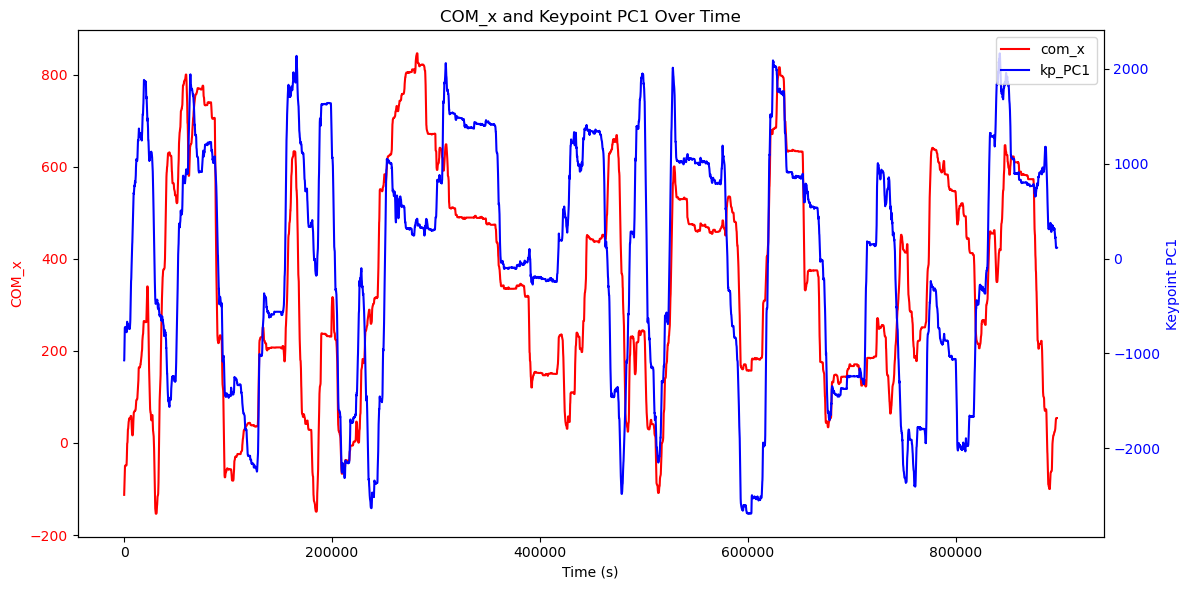

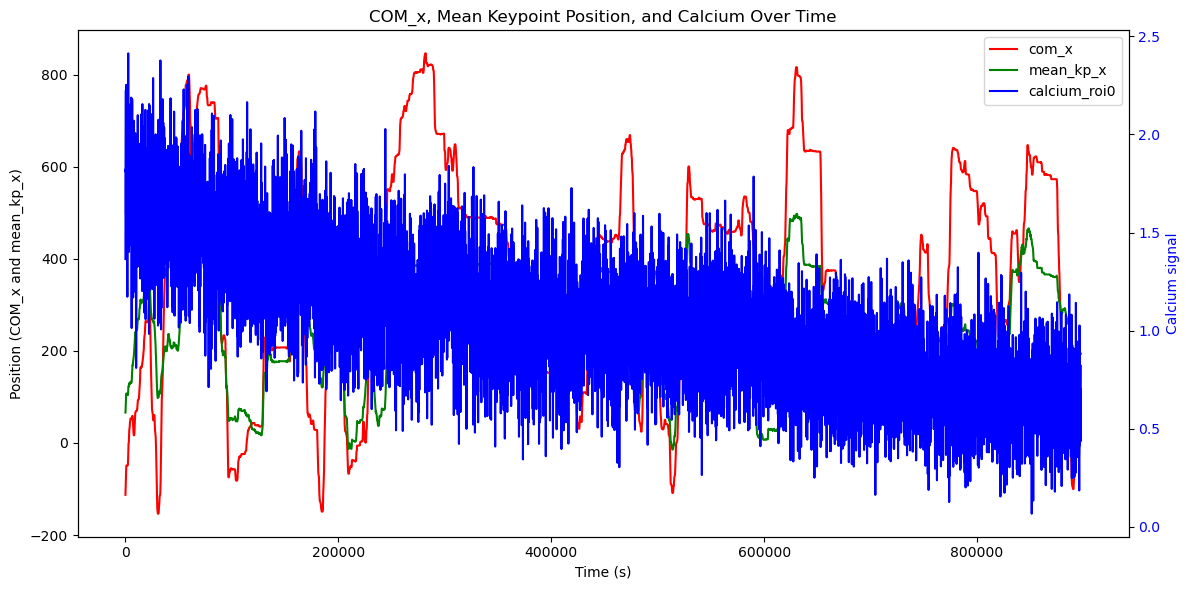

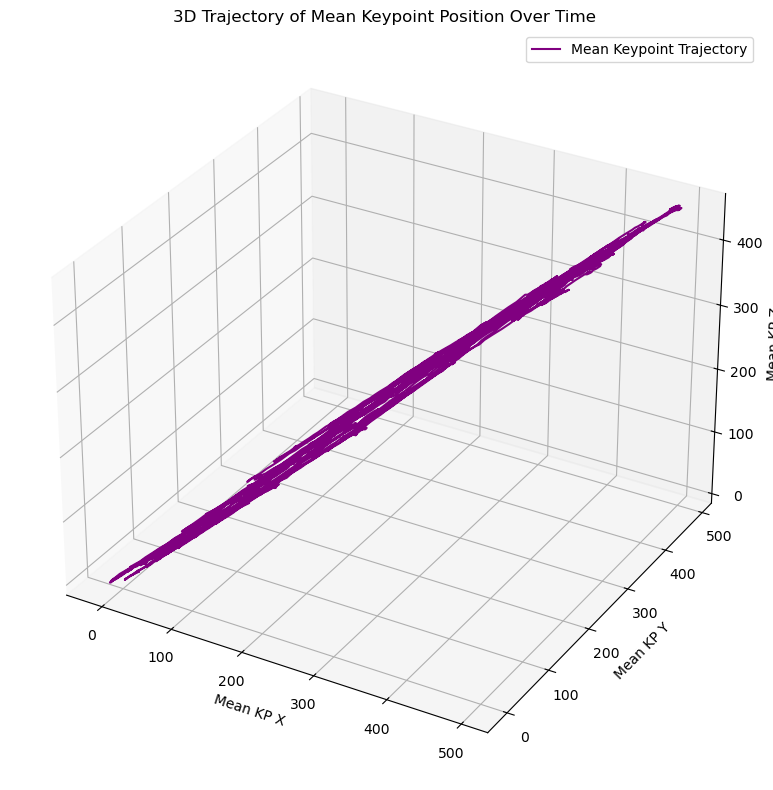

In [16]:
import matplotlib.pyplot as plt

##############################################################
# 1. PC1 vs. COM_x Over Time
##############################################################

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot COM_x on left y-axis
ax1.plot(df_merged.index, df_merged['com_x'], color='red', label='com_x')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('COM_x', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create second y-axis for PC1
ax2 = ax1.twinx()
ax2.plot(df_merged.index, df_merged['kp_PC1'], color='blue', label='kp_PC1')
ax2.set_ylabel('Keypoint PC1', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.title('COM_x and Keypoint PC1 Over Time')
plt.tight_layout()
plt.show()

##############################################################
# 2. Mean Keypoint Position, COM_x, and Calcium ROI
##############################################################

# For illustration, let's plot mean_kp_x and com_x on the left axis, and calcium_roi0 on the right axis

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot COM_x and mean_kp_x on left y-axis
ax1.plot(df_merged.index, df_merged['com_x'], color='red', label='com_x')
ax1.plot(df_merged.index, df_merged['mean_kp_x'], color='green', label='mean_kp_x')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (COM_x and mean_kp_x)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create second y-axis for Calcium
ax2 = ax1.twinx()

if 'calcium_roi0' in df_merged.columns:
    ax2.plot(df_merged.index, df_merged['calcium_roi0'], color='blue', label='calcium_roi0')
    ax2.set_ylabel('Calcium signal', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = (ax2.get_legend_handles_labels() if 'calcium_roi0' in df_merged.columns else ([], []))
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('COM_x, Mean Keypoint Position, and Calcium Over Time')
plt.tight_layout()
plt.show()

##############################################################
# 3. 3D Visualization of Mean Keypoint Positions (Optional)
##############################################################

# If you want to visualize how the mean keypoint position moves in 3D space over time:
# This is not time-aligned with COM or Calcium necessarily on the same plot, but gives a spatial sense of movement.
# We will create a 3D scatter plot of mean_kp_x, mean_kp_y, mean_kp_z over time.
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory in 3D
x = df_merged['mean_kp_x'].values
y = df_merged['mean_kp_y'].values
z = df_merged['mean_kp_z'].values
ax.plot(x, y, z, color='purple', label='Mean Keypoint Trajectory')

ax.set_xlabel('Mean KP X')
ax.set_ylabel('Mean KP Y')
ax.set_zlabel('Mean KP Z')
ax.legend()
plt.title('3D Trajectory of Mean Keypoint Position Over Time')
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Assuming you have a DataFrame `df_merged` with columns for each keypoint:
# The keypoint columns might be named 'kp1_x', 'kp1_y', 'kp1_z', ... etc.
# You must know the mapping from these indices to body parts.
# For 'mouse22_notail' labeling, indices might be:
# 'EarL' = 0, 'EarR' = 1, 'Snout' = 2, etc.
#
# Let's assume your keypoints follow the order in "mouse22_notail" labeling you provided:
bodyparts = [
    'EarL', 'EarR', 'Snout', 'SpineF', 'SpineM', 'Tail(base)', 'Tail(mid)', 'Tail(end)', 
    'ForepawL', 'WristL', 'ElbowL', 'ShoulderL', 
    'ForepawR', 'WristR', 'ElbowR', 'ShoulderR', 
    'HindpawL', 'AnkleL', 'KneeL', 'HindpawR', 'AnkleR'
]

# Ensure we have 22 keypoints (or the correct number based on your actual data)
# If you have only 22 body parts plus a tail end, adjust accordingly.
# Here, you've listed indices up to 21 in the connectivity, which suggests 22 total points (0 through 21).
# If your actual data has 22 * 3 columns: kp0_x, kp0_y, kp0_z, kp1_x... kp21_z,
# Adjust indexing accordingly.

# Identify indices for head points:
earL_idx = bodyparts.index('EarL')    # likely 0
earR_idx = bodyparts.index('EarR')    # likely 1
snout_idx = bodyparts.index('Snout')  # likely 2

# Extract their columns from df_merged
# Assuming columns are named kp{idx}_x, kp{idx}_y, kp{idx}_z
def get_kp_coordinates(df, kp_index):
    x = df[f'kp{kp_index}_x'].values
    y = df[f'kp{kp_index}_y'].values
    z = df[f'kp{kp_index}_z'].values
    return x, y, z

earL_x, earL_y, earL_z = get_kp_coordinates(df_merged, earL_idx)
earR_x, earR_y, earR_z = get_kp_coordinates(df_merged, earR_idx)
snout_x, snout_y, snout_z = get_kp_coordinates(df_merged, snout_idx)

# Compute head center (average position of EarL, EarR, Snout)
head_center_x = (earL_x + earR_x + snout_x) / 3.0
head_center_y = (earL_y + earR_y + snout_y) / 3.0
head_center_z = (earL_z + earR_z + snout_z) / 3.0

# Add these to the DataFrame
df_merged['head_center_x'] = head_center_x
df_merged['head_center_y'] = head_center_y
df_merged['head_center_z'] = head_center_z

# If you want a direction vector, for example:
# Vector from midpoint of ears to snout:
ear_mid_x = (earL_x + earR_x) / 2.0
ear_mid_y = (earL_y + earR_y) / 2.0
ear_mid_z = (earL_z + earR_z) / 2.0

# Direction vector = snout - ear_mid
head_dir_x = snout_x - ear_mid_x
head_dir_y = snout_y - ear_mid_y
head_dir_z = snout_z - ear_mid_z

# Normalize the direction vector to length 1 for an orientation measure
head_dir_norm = np.sqrt(head_dir_x**2 + head_dir_y**2 + head_dir_z**2)
head_dir_x_norm = head_dir_x / (head_dir_norm + 1e-9)
head_dir_y_norm = head_dir_y / (head_dir_norm + 1e-9)
head_dir_z_norm = head_dir_z / (head_dir_norm + 1e-9)

df_merged['head_dir_x'] = head_dir_x_norm
df_merged['head_dir_y'] = head_dir_y_norm
df_merged['head_dir_z'] = head_dir_z_norm

##############################################################
# Correlate head_center_x with calcium_roi0 (if present)
##############################################################

if 'calcium_roi0' in df_merged.columns:
    r, p_val = pearsonr(df_merged['head_center_x'], df_merged['calcium_roi0'])
    print("Correlation between head_center_x and calcium_roi0:", r, p_val)

##############################################################
# Visualization Example
##############################################################

# Plot head_center_x and com_x on left axis, and a calcium ROI on right axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_merged.index, df_merged['head_center_x'], color='purple', label='head_center_x')
ax1.plot(df_merged.index, df_merged['com_x'], color='red', label='com_x')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (head_center_x, com_x)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# If calcium is present, plot on second y-axis
ax2 = ax1.twinx()
if 'calcium_roi0' in df_merged.columns:
    ax2.plot(df_merged.index, df_merged['calcium_roi0'], color='blue', label='calcium_roi0')
    ax2.set_ylabel('Calcium signal', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
if 'calcium_roi0' in df_merged.columns:
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1+lines2, labels1+labels2, loc='upper right')
else:
    ax1.legend(loc='upper right')

plt.title('Head Center X, COM_x, and Calcium Over Time')
plt.tight_layout()
plt.show()

##############################################################
# If you want to visualize head direction changes over time:
##############################################################

# For instance, plot head_dir_x alongside com_x
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_merged.index, df_merged['head_dir_x'], color='green', label='head_dir_x')
ax1.plot(df_merged.index, df_merged['com_x'], color='red', label='com_x')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Head_dir_x and COM_x', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend()
plt.title('Head Direction (X component) and COM_x Over Time')
plt.tight_layout()
plt.show()


KeyError: 'kp0_x'

In [ ]:
# this giantic things porb need more work, as i need to load the frames and then match the frames???? from each vid, so not so easy.....

# import os
# import numpy as np
# import imageio
# import matplotlib.pyplot as plt
# from matplotlib.animation import FFMpegWriter
# from matplotlib import patches
# from scipy.sparse import csc_matrix
# import tqdm
# sys.path.append(os.path.abspath('../..'))
# from utlis.projection import *
# import utlis.connectivity


# # Assumed available from your existing code/environment:
# # pred_2d[cam][frame]: 2D positions of keypoints for the 6Cam frame
# # COLOR, CONNECTIVITY: defines skeleton connectivity and colors
# # mini_cam_vid: Path to miniscope video
# # video_path: Path to 6Cam video
# # all_rois: a binary mask of ROIs (H, W)
# # C: (num_neuron, num_frame) Ca signals
# # ts: (num_frame,) timestamps in ms for Ca data
# # mini_cam_timestamps_s: timestamps in seconds (if needed) - not strictly here if just a demo
# # START_FRAME, N_FRAMES: define the chunk of data you visualize

# # For demonstration, let's assume you have these variables defined:
# # video_path (6Cam)
# # mini_cam_vid (Miniscope)
# # pred_2d (keypoints)
# # COLOR, CONNECTIVITY (animal skeleton info)
# # C, ts (calcium signals and timestamps)
# # all_rois (ROI mask)
# # START_FRAME, N_FRAMES
# N_FRAMES = 10
# START_FRAME = 10
# A = np.array(data['A'].values)

# try:
#     # Convert from sparse to dense if necessary (CSC or CSR format typically)
#     from scipy.sparse import csc_matrix
#     A_dense = csc_matrix((A.data, A.indices, A.indptr), shape=A.shape).toarray()
# except AttributeError:
#     # If 'A' is already dense
#     A_dense = A

# # Sum along the first axis to create a binary image of all ROIs
# # This assumes non-overlapping ROIs; if ROIs overlap, this will show overlap areas as brighter
# all_rois = np.clip(np.sum(A_dense, axis=0), 0, 1)
# # If not defined, you'll need to define or load them as per your scenario.
# video_path = os.path.join(rec_path, 'videos/Camera1/0.mp4')
# mini_cam_vid = os.path.join(miniscope_path, '0.avi')
# # mini_cam_vid = sorted(glob.glob(os.path.join(miniscope_path, '[0-9].avi')))
# # Open the 6Cam and Miniscope videos
# vid_6cam = imageio.get_reader(video_path)
# vid_mini = imageio.get_reader(mini_cam_vid)

# # Setup metadata for saving a video output
# save_path = os.path.join(rec_path,"combined_visualization")
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# VID_NAME = "combined_demo.mp4"
# metadata = dict(title='combined_visualization', artist='Matplotlib')
# writer = FFMpegWriter(fps=20, metadata=metadata) 

# fig = plt.figure(figsize=(10,8))
# gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])  # top row for videos, bottom row for Ca signals

# ax_6cam = fig.add_subplot(gs[0,0])
# ax_mini = fig.add_subplot(gs[0,1])
# ax_ca = fig.add_subplot(gs[1,:])

# plt.tight_layout()

# # Plot all Ca signals in ax_ca
# # Shift each neuron trace upward to separate them visually
# num_neuron = C.shape[0]
# offset = 20
# for i in range(num_neuron):
#     ax_ca.plot(ts, C[i,:] + i*offset, color='black')

# ax_ca.set_xlabel('Time (ms)')
# ax_ca.set_ylabel('Calcium signals (shifted)')
# ax_ca.set_title('Calcium Activity')
# ax_ca.set_xlim(ts[0], ts[-1])
# # Vertical line to indicate current frame/time
# time_line = ax_ca.axvline(ts[0], color='red', linestyle='--')

# # Convert all_rois (H,W) into RGBA overlay
# # For a simple overlay, we can just show it as a semi-transparent mask.
# # We'll do that dynamically when plotting.
# # We'll need the height and width from all_rois
# H, W = all_rois.shape

# with writer.saving(fig, os.path.join(save_path, VID_NAME), dpi=150):
#     for frame_i in tqdm.tqdm(range(N_FRAMES)):
#         current_frame = START_FRAME + frame_i

#         # Clear axes of the top row for new frame
#         ax_6cam.clear()
#         ax_mini.clear()

#         # Get frames
#         img_6cam = vid_6cam.get_data(current_frame)
#         img_mini = vid_mini.get_data(frame_i)  # Assuming miniscope frames align 1-to-1 or already mapped

#         # Show images
#         ax_6cam.imshow(img_6cam)
#         ax_6cam.set_title("6Cam Video with Skeleton")
#         ax_6cam.axis("off")

#         # Plot skeleton keypoints on 6Cam
#         kpts_2d = pred_2d['Camera2'][frame_i]  # Adjust camera name as needed
#         # Plot keypoints
#         ax_6cam.scatter(kpts_2d[:, 0], kpts_2d[:, 1], marker='.', color='white', alpha=0.5)
#         # Connect them
#         for color, (index_from, index_to) in zip(COLOR, CONNECTIVITY):
#             # xs, ys = [kpts_2d[index_from, j], kpts_2d[index_to, j]] for j in range(2)
#             xs, ys = ([kpts_2d[index_from, j], kpts_2d[index_to, j]] for j in range(2))
#             ax_6cam.plot(xs, ys, c=color, lw=2)

#         # Show Miniscope video
#         ax_mini.imshow(img_mini, cmap='gray')
#         ax_mini.set_title("Miniscope Video with ROIs")
#         ax_mini.axis("off")

#         # Overlay ROI mask
#         # Create an RGBA version of all_rois
#         # where the ROIs are semi-transparent red overlay
#         overlay = np.zeros((H, W, 4), dtype=np.float32)
#         overlay[...,0] = 1.0  # Red channel
#         overlay[...,3] = 0.3 * all_rois  # Alpha channel scaled by 0.3
#         # Overlay on top of the miniscope frame using imshow with alpha
#         # Need to ensure same size as miniscope frame, if not, resize or crop.
#         # Assuming they match in size. If not, you'd need to handle resizing.
#         ax_mini.imshow(overlay)

#         # Update the vertical line position in Ca plot
#         current_ts = ts[frame_i] if frame_i < len(ts) else ts[-1]
#         time_line.set_xdata(current_ts)

#         # Redraw
#         fig.canvas.draw()
#         writer.grab_frame()

# # After the loop, the video is saved
# print(f"Video saved at: {os.path.join(save_path, VID_NAME)}")


OSError: Cannot understand given URI: ['/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sor....